## 空间数据的探索性分析

In [1]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
import geopandas as gpd
import splot

#### 示例数据

In [2]:
link_to_data = 'data/guerry/guerry.shp'

gdf = gpd.read_file(link_to_data)

<Axes: >

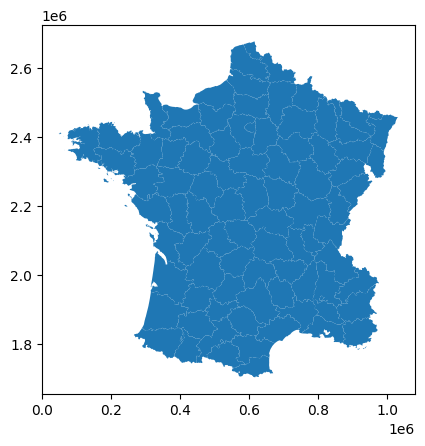

In [3]:
gdf.plot()

在这个例子中，将重点关注Donatns（人均慈善捐款）变量。使用 计算连续权重。然后，我们将权重转换为行标准化。

In [4]:
y = gdf['Donatns'].values
w = Queen.from_dataframe(gdf, use_index=True)
w.transform = 'r'

### 评估全局空间自相关
计算莫兰的 I。连续属性的全局自相关检验。

In [5]:
from esda.moran import Moran

w = Queen.from_dataframe(gdf, use_index=True)
moran = Moran(y, w)
moran.I

0.3533613255848606

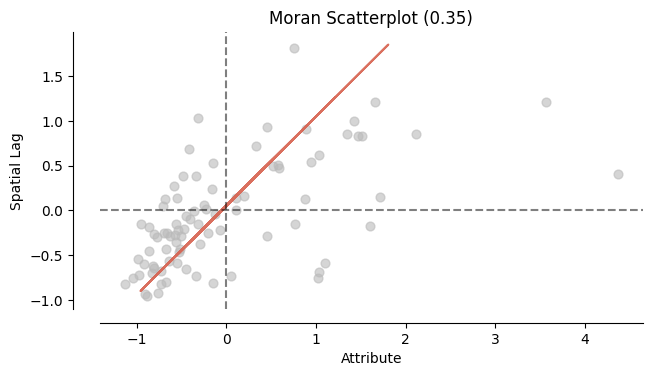

In [6]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

在完全空间随机性的原假设下，根据参考分布来解释统计值。PySAL使用随机空间排列的方法。

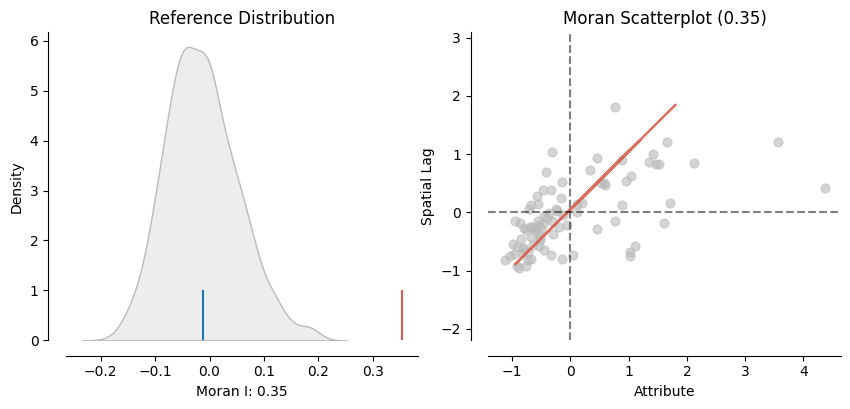

In [7]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

### 可视化与图的局部自相关-热点、冷点和空间异常值

除了可视化全局自相关统计量外，splot 还具有可视化局部自相关统计量的选项。  
计算局部 Moran 。然后在 Moran 散点图中绘制空间滞后和 Donatns 变量。

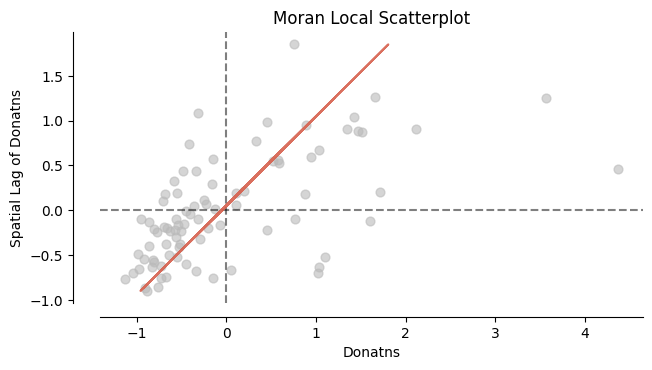

In [8]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

可以区分高-高、低-低、高-低、低-高的局部空间自相关具体类型。 其中右上象限显示 HH、左下象限、LL、左上象限显示 LH 和左下象限。  
这些类型的局部空间自相关描述了特定多边形与其相邻多边形之间的相似性或不同性。例如，左上象限表示低值的多边形被高值 （LH） 的多边形包围。右下象限显示高值的多边形，周围环绕着低值的邻居 （HL）。这表示不同值的关联。

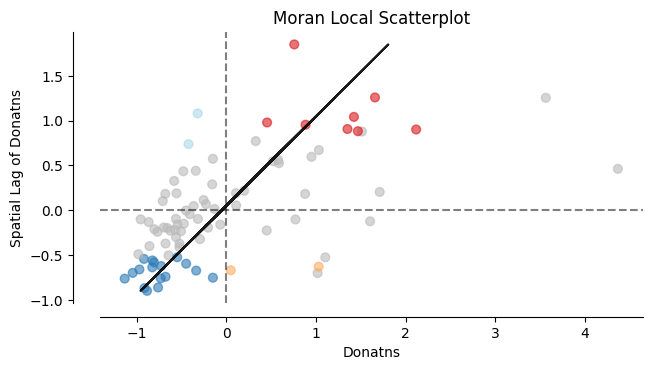

In [9]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

可视化在地图上发现的重要区域

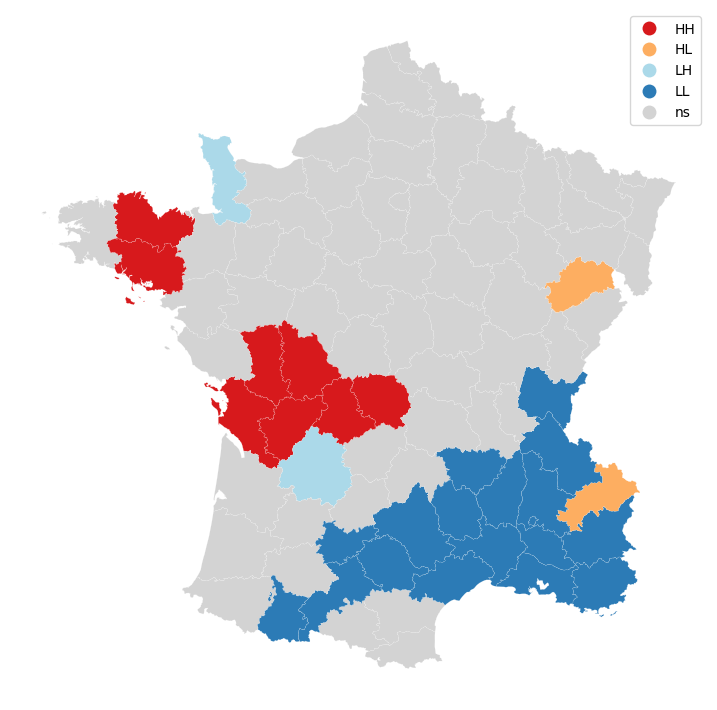

In [10]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
plt.show()

### 组合可视化效果

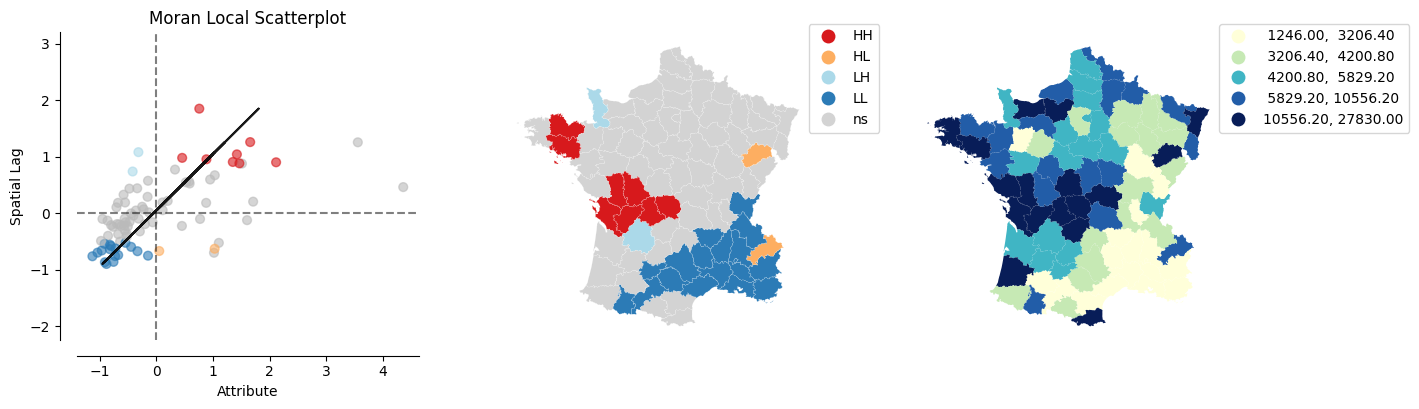

In [11]:
from splot.esda import plot_local_autocorrelation

plot_local_autocorrelation(moran_loc, gdf, 'Donatns')
plt.show()

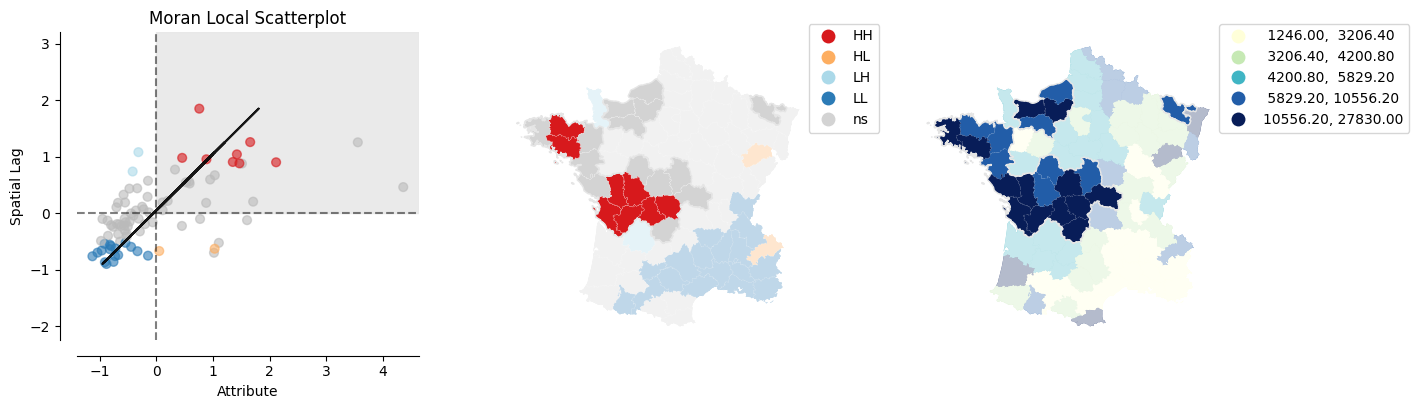

In [12]:
plot_local_autocorrelation(moran_loc, gdf, 'Donatns', quadrant=1)
plt.show()

### 双变量莫兰统计量

此外，评估一个变量在空间上的相关性。可以使用所谓的双变量莫兰统计来检查两个变量的关系鞭及其在空间中的位置。这些可以在 `esda.moran.Moran_BV` 中找到。

In [13]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [14]:
x = gdf['Suicids'].values

深入研究二元 Moran 启动论之前，快速浏览一下哪些对象受以下支持：`esda.moran`、`moran_scatterplot`

In [15]:
moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)

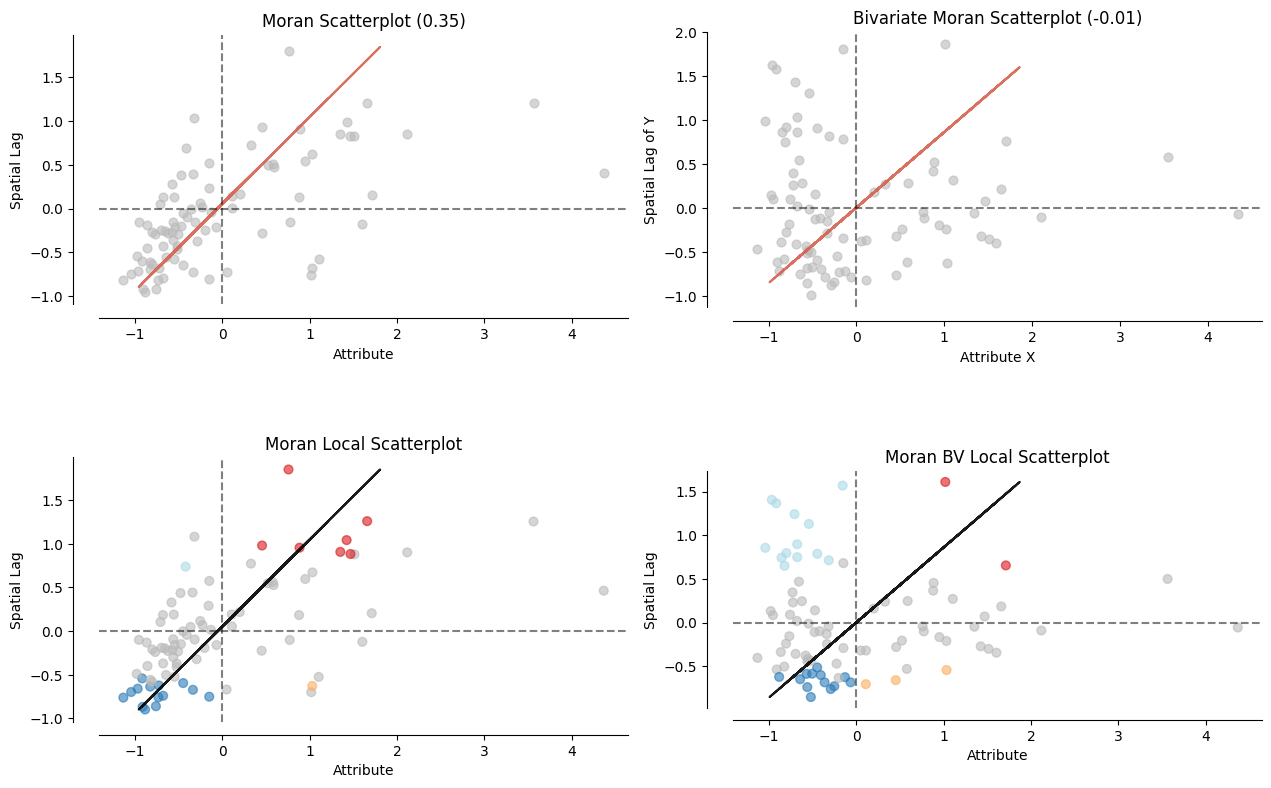

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,10),
                        subplot_kw={'aspect': 'equal'})

moran_scatterplot(moran, ax=axs[0,0])
moran_scatterplot(moran_loc, p=0.05, ax=axs[1,0])
moran_scatterplot(moran_bv, ax=axs[0,1])
moran_scatterplot(moran_loc_bv, p=0.05, ax=axs[1,1])
plt.show()

双变量莫兰统计描述了一个变量与另一个变量的空间滞后之间的相关性。因此，我们必须谨慎地解释我们的结果。双变量莫兰统计不考虑同一位置的两个变量之间的固有相关性。它们更多地提供了一种工具，用于测量具有特定属性的多边形与其具有不同属性的相邻多边形的相关性。

`splot`可以通过提供参考分布的可视化和莫兰散点图来帮助解释结果：

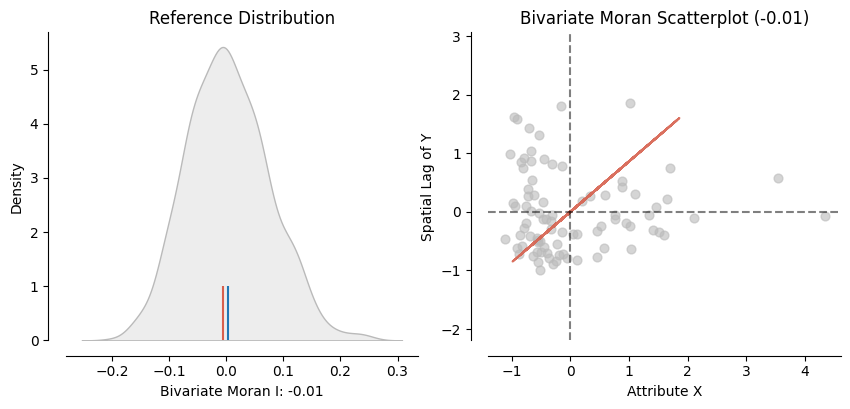

In [17]:
plot_moran_bv(moran_bv)
plt.show()

### 局部双变量莫兰统计量

类似于单变量局部 Moran 统计量，并提供用于评估双变量分析的局部自相关工具：`pysal splot`

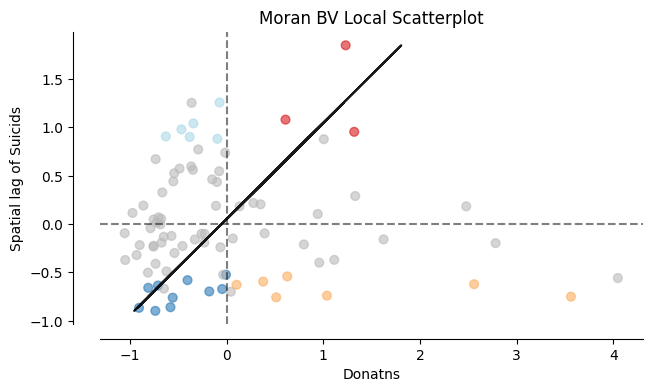

In [18]:
from esda.moran import Moran_Local_BV

moran_loc_bv = Moran_Local_BV(x, y, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial lag of Suicids')
plt.show()

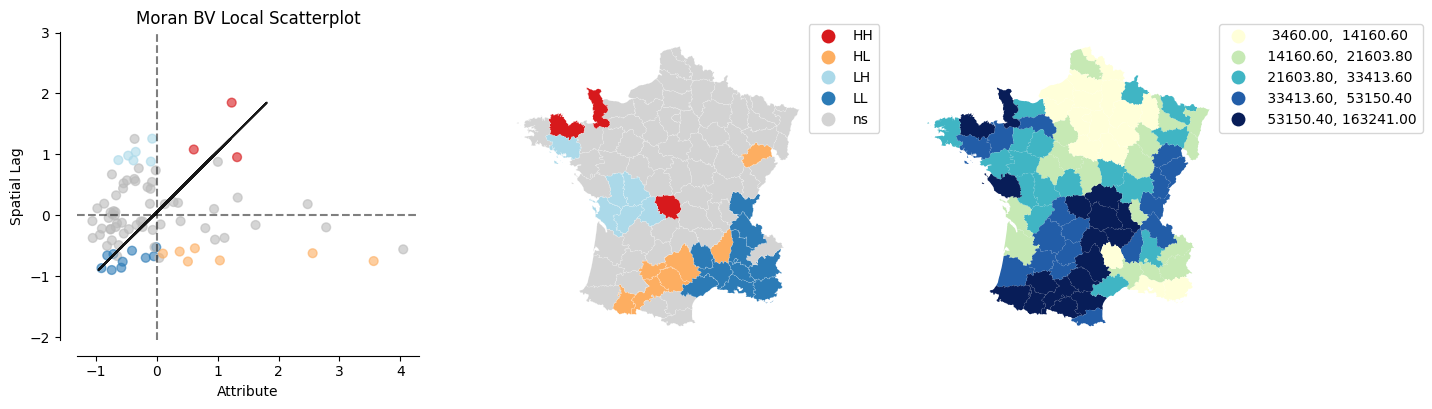

In [19]:
plot_local_autocorrelation(moran_loc_bv, gdf, 'Suicids')
plt.show()

### 地理加权回归

In [20]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

<Axes: >

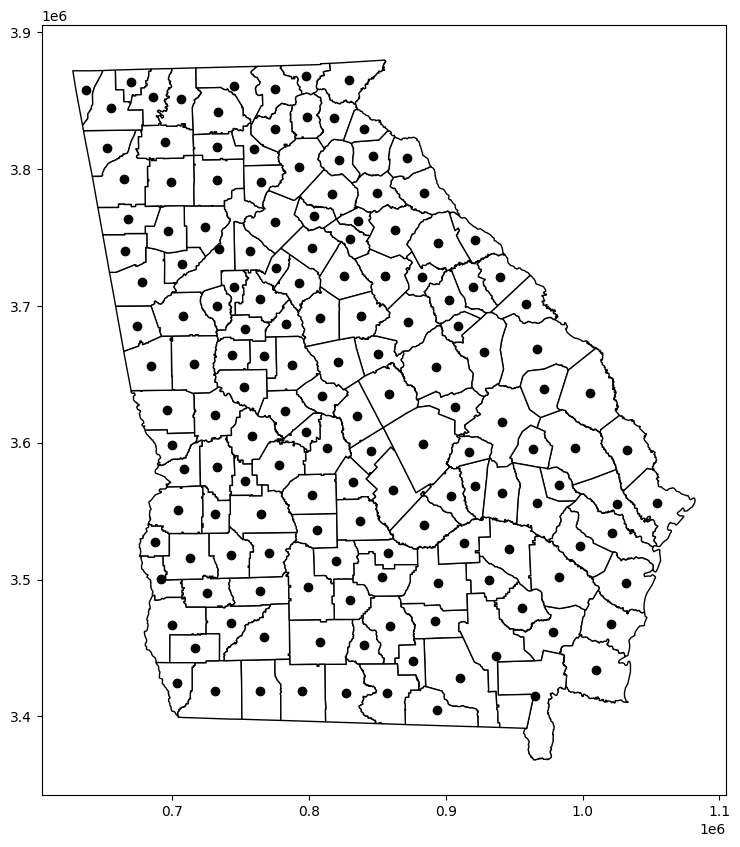

In [21]:
georgia_data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
georgia_shp = gp.read_file(ps.examples.get_path('G_utm.shp'))
fig, ax = plt.subplots(figsize=(10,10))
georgia_shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
georgia_shp.centroid.plot(ax=ax, c='black')

In [22]:
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [23]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

117.0


In [24]:
gwr_results.params[0:5]

array([[-0.23204579,  0.22820815,  0.05697445, -0.42649461],
       [-0.2792238 ,  0.16511734,  0.09516542, -0.41226348],
       [-0.248944  ,  0.20466991,  0.07121197, -0.42573638],
       [-0.23036768,  0.1527493 ,  0.0510379 , -0.35938659],
       [ 0.19066196,  0.71627541, -0.16920186, -0.24091753]])

In [25]:
gwr_results.localR2[0:10]

array([[0.55932878],
       [0.5148705 ],
       [0.54751792],
       [0.50691577],
       [0.69062134],
       [0.69429812],
       [0.69813709],
       [0.70867337],
       [0.49985703],
       [0.49379842]])

In [26]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [27]:
georgia_data

,AreaKey,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,ID,X,Y
0,13001,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,133,941396.6,3521764.0
1,13003,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,158,895553.0,3471916.0
2,13005,31.55678,-82.45115,9566,61.7,6.6,11.11,0.27,24.1,15.42,146,930946.4,3502787.0
3,13007,31.33084,-84.45401,3615,100.0,9.4,13.17,0.11,24.8,51.67,155,745398.6,3474765.0
4,13009,33.07193,-83.25085,39530,42.7,13.3,8.64,1.43,17.5,42.39,79,849431.3,3665553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,13313,34.80497,-84.96616,72462,70.0,12.0,9.48,2.55,11.1,4.06,6,686891.4,3855274.0
155,13315,31.97034,-83.43574,7008,100.0,7.6,15.71,0.09,28.6,31.76,124,838551.5,3538547.0
156,13317,33.78664,-82.74436,10597,59.6,10.4,16.64,0.43,22.6,45.94,39,891228.5,3749769.0
157,13319,32.79853,-83.16759,10228,100.0,8.8,11.36,0.29,15.3,41.99,82,858796.9,3637891.0


In [28]:
georgia_shp

,AREA,PERIMETER,G_UTM_,G_UTM_ID,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
0,1.331370e+09,207205.0,132,133,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,941396.6,3521764,13001,"POLYGON ((931869.062 3545540.500, 934111.625 3..."
1,8.929300e+08,154640.0,157,158,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,895553.0,3471916,13003,"POLYGON ((867016.312 3482416.000, 884309.375 3..."
2,7.434020e+08,130431.0,148,146,31.55678,-82.45115,9566,61.7,6.6,11.11,0.27,24.1,15.42,930946.4,3502787,13005,"POLYGON ((914656.875 3512190.000, 924718.375 3..."
3,9.053950e+08,185737.0,158,155,31.33084,-84.45401,3615,100.0,9.4,13.17,0.11,24.8,51.67,745398.6,3474765,13007,"POLYGON ((744258.625 3480598.500, 765025.062 3..."
4,6.941830e+08,151347.0,76,79,33.07193,-83.25085,39530,42.7,13.3,8.64,1.43,17.5,42.39,849431.3,3665553,13009,"POLYGON ((832974.188 3677273.500, 834048.688 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,7.528500e+08,174980.0,7,6,34.80497,-84.96616,72462,70.0,12.0,9.48,2.55,11.1,4.06,686891.4,3855274,13313,"POLYGON ((684405.938 3873304.500, 684661.562 3..."
155,9.935170e+08,160299.0,128,124,31.97034,-83.43574,7008,100.0,7.6,15.71,0.09,28.6,31.76,838551.5,3538547,13315,"POLYGON ((845655.625 3557787.750, 846281.250 3..."
156,1.230650e+09,180896.0,40,39,33.78664,-82.74436,10597,59.6,10.4,16.64,0.43,22.6,45.94,891228.5,3749769,13317,"POLYGON ((902279.938 3768771.750, 906628.562 3..."
157,1.175160e+09,161482.0,83,82,32.79853,-83.16759,10228,100.0,8.8,11.36,0.29,15.3,41.99,858796.9,3637891,13319,"POLYGON ((867125.062 3651962.750, 867417.750 3..."


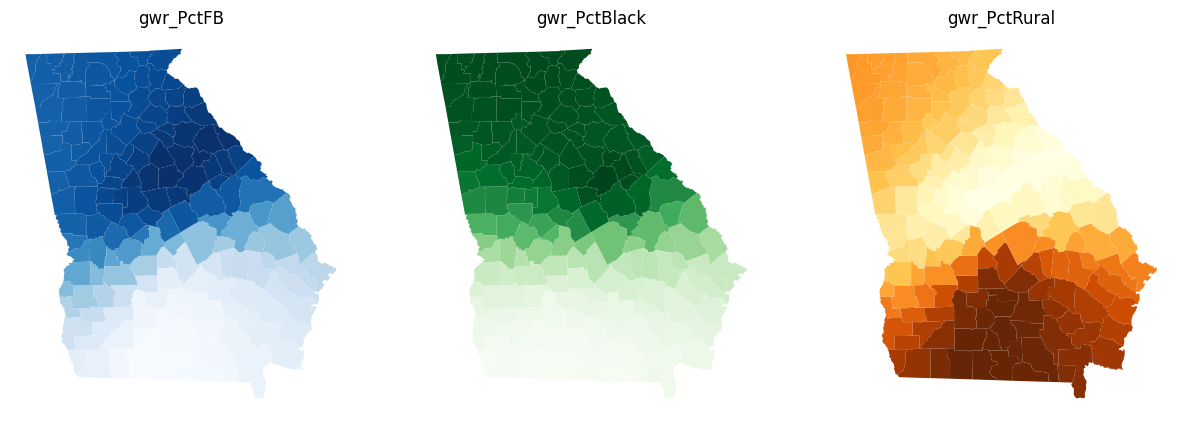

In [29]:
features = ['PctFB', 'PctBlack', 'PctRural']
for i,fea in enumerate(features):
    georgia_data['gwr_' + fea] = gwr_results.params[:,i]
cmaps = ['Blues','Greens','YlOrBr']
georgia_shp1 = georgia_shp.merge(georgia_data[['AreaKey']+['gwr_'+fea for fea in features]], on='AreaKey', how='left')
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i,fea in enumerate(features):
    fea = 'gwr_' + fea
    georgia_shp1.plot(column=fea, cmap=cmaps[i], ax=ax[i])
    ax[i].set_title(fea)
    ax[i].set_axis_off()